<a href="https://colab.research.google.com/github/Sofinelye/-Neuro-linguistic-programming/blob/master/LP_CAR_ALLOCATION_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Import libraries and formulate problems

In [3]:
pip install pulp

     |████████████████████████████████| 14.2 MB 5.5 MB/s 


In [4]:
import pulp
# from utils import *
import numpy as np
from Monte_Carlo_Process import *
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

ModuleNotFoundError: ignored

In [1]:
def set_up_parameters(c,r,h_r,h_i,p,B,I_n,T_n,S):
    parameters={}
    parameters["c"]=c
    parameters["r"]=r
    parameters["h_r"]=h_r
    parameters["h_i"]=h_i
    parameters["p"]= p
    parameters["B"]=B
    parameters["I_n"]=I_n
    parameters["T_n"]=T_n
    parameters['S']=S
    
#     total_flows = {
#         "demand":0,"idle":0,"reposition":0
#     }
    
    return parameters

### 2. Upload file and Construct the Spatial-temporal Network G(N,A)

In [ ]:
class create_network:
    def __init__(self):
        self.flow_MAT = {}
    
    def reset_MAT(self,parameters):
        I_n= parameters["I_n"]
        T_n= parameters["T_n"]
        supply_MAT = np.zeros((I_n,T_n))
        idles_MAT = np.zeros((I_n,T_n))
        self.flow_MAT["supply"] = supply_MAT
        self.flow_MAT["idles"] = idles_MAT

### 3. Set up the Model

### 3.1 Set up and Solve the two-stage stochastic Problem 

In [ ]:
def LP_stage_one(t_o,parameters,horizon,fulfill_rate,requests): 
    '''   
    inputs: t: time node 
            parameters: parameters
            fulfill_rate: the lowest fulfillment rate
            demand_ful: dictionary which stores the demand fulfillment arc
            horizon: number of time period is being considered in one horizon
    outputs: 
            cost:stage one cost
            a: supply at each location at time t = 0
            demand_ful: updated demand_ful
    '''   
    I_n = parameters["I_n"]
    T_n=parameters["T_n"]
    c = parameters["c"]
    r=parameters["r"]
    h_r= parameters["h_r"]
    h_i = parameters["h_i"]
    p = parameters["p"]
    B=parameters["B"]
    S=parameters["S"]
    t_end = min(t_o+horizon+1,T_n) #horizon number of time period
        
    #Set up the LP problem
    prob = pulp.LpProblem("Stage_One", pulp.LpMinimize)

    #Set up the variables      
    #variables include flow at idle arc, at relocation arc and supply at each node 
    fi_dict, fr_dict, x_dict, fd_dict = {},{},{},{} 
    #f_dict = {  s: { t:{name: pulp.variables } }  }  except for fd_dict and fr_dict = {s:{name:}}
    fd_obj= []    
    
    for s in range(1,S+1):
        fi_dict[s] , fr_dict[s], x_dict[s],fd_dict[s] = {},{},{},{}
        
        #fd (fulfilled demand flow): the flow on the arc should be no greater than the requests 
        #name convention: s_fd_t_t'_i_j
        for pair in requests[s]:
            name_fd = "s"+str(s)+"_fd_"+pair
            t_start,t_d, zone_start,zone_end = pair.split("_")
            request_flow = requests[s][pair]
            fd_dict[s][name_fd]= pulp.LpVariable(name=name_fd,lowBound = 0,upBound = request_flow,
                                              cat="Integer")  
            fd_obj.append(fd_dict[s][name_fd]*(int(t_d)-int(t_start)))

            
            #fr (reposition flow): 
            #name convention: s_fr_t_t'_i_j: reposition vehicle from region i to j can take 1 or 2 time period
#             if int(t_d)-int(t_start)==1:
            name_fr = "s"+str(s)+"_fr_"+pair
#             print(name_fr)
            fr_dict[s][name_fr]= pulp.LpVariable(name=name_fr,lowBound = 0,cat="Integer") 
                                                  
                    
        for t in range(t_o,t_end+1):          
            fi_dict[s][t], x_dict[s][t] = {},{}         
            for i in range(1,I_n+1):
                
                #fi (idle flow): the flow is always from i->i and t->t+1
                #name convention: s_fi_t_i 
                name_fi="s"+str(s)+"_fi_"+str(t)+"_"+str(i)
                fi_dict[s][t][name_fi]= pulp.LpVariable(name=name_fi,lowBound = 0,cat="Integer")
                                                                                                     
                #x (supply level): 
                #name convention: s_x_t_i
                name_x="s"+str(s)+"_x_"+str(t)+"_"+str(i)
                x_dict[s][t][name_x]=pulp.LpVariable(name=name_x,lowBound = 0,cat="Integer")                                 
                
                #Constraints
                    
                #C1: Flow balance at each node n_it               
                if t<t_end: #truncate at t_end
                    
                    #outbound:
                    prob+=(
                        #supply at n_i,t:
                        x_dict[s][t][name_x]

                        #idle flow from n_it:
                        -fi_dict[s][t][name_fi]

                        #demands flow from n_it:
                        -(pulp.lpSum(fd_dict[s][name] for name in fd_dict[s] 
                                     if name.split("_")[2] == str(t) and name.split("_")[4]==str(i))
                         )
                        
                        #reposition flow from n_it:
                        -(pulp.lpSum(fr_dict[s][name] for name in fr_dict[s] 
                                     if name.split("_")[2] == str(t) and name.split("_")[4]==str(i))
                         )
                    )==0
                    
                
                    #inbound:
                if t>t_o:
                    prob+= (
                        #supply at n_i,(t+1):
                        x_dict[s][t][name_x]
                        
                        #idle flow towards n_it:
                        -fi_dict[s][t-1]["s"+str(s)+"_fi_"+str(t-1)+"_"+str(i)]
                        
                        #demands flow toward n_it:
                        -(pulp.lpSum(fd_dict[s][name] for name in fd_dict[s] 
                                     if name.split("_")[3] == str(t) and name.split("_")[5]==str(i))
                         )
                        
                         #reposition flow toward n_it:
                        -(pulp.lpSum(fr_dict[s][name] for name in fr_dict[s] 
                                     if name.split("_")[3] == str(t) and name.split("_")[5]==str(i))
                         )                                    
                    
                    )==0
        
        #C2: TOTAL s_x_1_i from all scenarios share the same value (as s = 1)
#         if s!=1:
#             s1_name = "s"+str(1)+"_"+"x"+"_"+str(1)+"_"+str(i)
#             prob+=pulp.lpSum(x_dict[s][1]) - pulp.lpSum(x_dict[1][1])==0 
            
                if s!=1 and t==1:
                    s1_name = "s"+str(1)+"_"+"x"+"_"+str(1)+"_"+str(i)
                    prob+=x_dict[s][t][name_x]-x_dict[1][t][s1_name]==0
            
        #C3: total actual fulfilled demands >= total fulfillment rate*requests
        if fulfill_rate:
            prob+= (pulp.lpSum(fd_dict[s]))-fulfill_rate*(pulp.lpSum(requests[s]))>=0
    
    Total_vehicle = pulp.lpSum(x_dict[t_o][1])
    idle_cost = h_i*pulp.lpSum(fi_dict)   
    reposition_cost = h_r*pulp.lpSum(fr_dict)
    revenue = r*pulp.lpSum(fd_obj)
    penalty=p*(pulp.lpSum(requests)-pulp.lpSum(fd_dict))
    
    prob+= (
        #stage-one cost: initialization
        c*Total_vehicle
        #expected stage-two cost
        +1/S*(idle_cost+reposition_cost+penalty-revenue)
    )
           
    status=prob.solve()
    cache = {}
    cache["min_fulfilment_rate"]=fulfill_rate
    actual_rate=0
    cache["actual_rate_list"]= []
#     cache['fleet_size'] = []
#     for i in range(1,I+1):
#         cache['fleet_size']=pulp.value(x_dict[1][1]
    
    for s in range(1,S+1):
        curr_rate = pulp.value(pulp.lpSum(fd_dict[s]))/pulp.value(pulp.lpSum(requests[s]))
        actual_rate+=curr_rate
        cache["actual_rate_list"].append(curr_rate)
    cache["actual_fulfilment_rate"] = pulp.value(pulp.lpSum(fd_dict))/pulp.value(pulp.lpSum(requests))
    cache["number_of_vehicles"]=pulp.value(Total_vehicle)
    cache["total_cost"]= pulp.value(prob.objective)
    cache["avg_cost_idle"]=pulp.value(1/S*h_i*pulp.lpSum(fi_dict))
    cache["avg_cost_reposition"]=pulp.value(1/S*h_i*pulp.lpSum(fr_dict))
    cache["avg_cost_revenue"]=pulp.value(1/S*revenue)
    cache["avg_penalty"]=pulp.value(1/S*penalty)
    
    return cache


### 3.2 Run the test

### 3.2.1 Set up variables
#### Variables:
    - depreciation value c per vehicle per day
    - positive impact r, revenue per time period per car
    - reposition cost h_r, cost per time period per car
    - idle cost h_i, cost per time period per car
    - p penalty if demand is not fulfilled per request
    - budget B per day,
    - Zone number I_n
    - Time period T, time point T_n
    - Number of scenarios: S
    


In [ ]:
c=54
r = 5
h_r = 3
h_i = 0.5
B=5500
p = 2 
I_n = 8
T_n = 21
S =90
parameters=set_up_parameters(c,r,h_r,h_i,p,B,I_n,T_n,S)

#### Generate random samples

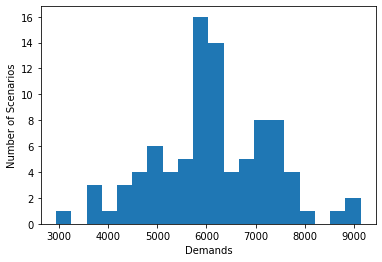

<Figure size 432x288 with 0 Axes>

In [ ]:
samples_demands = generate_trip_size(I_n,T_n,S)
graph = create_network()
# print(graph.demands)

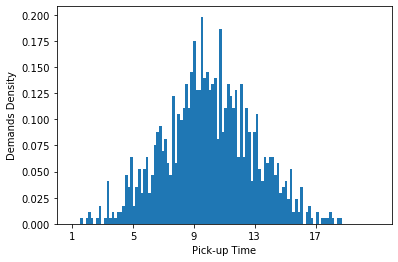

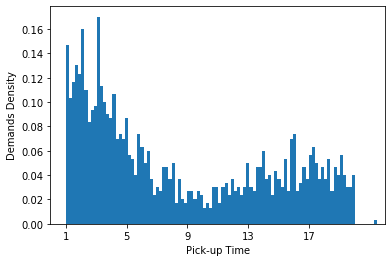

In [ ]:
g_normal=generate_samples(I_n,T_n,samples_demands,1)
g_bi = generate_samples(I_n,T_n,samples_demands,dist_type=2)
g_uni = generate_samples(I_n,T_n,samples_demands,dist_type=3)

In [ ]:
def driver(

    range_rate=np.linspace(0.7, 1, num=7),
    parameters=parameters,
    requests = g_normal
):
    cache_lst = [] #cache list for each fulfillment rate
    for fulfill_rate in [0,0.5]:
        print(fulfill_rate)
        cache_lst.append(LP_stage_one(t_o=1,parameters=parameters,horizon = 22,fulfill_rate = fulfill_rate,requests=requests))       
       
    for fulfill_rate in range_rate:
        print(fulfill_rate)
        cache_lst.append(LP_stage_one(t_o=1,parameters=parameters,horizon = 22,fulfill_rate = fulfill_rate,requests=requests))

    print("Done!")
    return cache_lst

In [ ]:
def driver_price(
    r = [i for i in range(2,7)],
    requests = g_uni
):
    cache_lst = [] #cache list for each unit flow cost 
    
#     parameters=set_up_parameters(c,r,h_r,h_i,p,B,I_n,T_n,S)
#     graph = create_network()
#     graph.generate_random_demands(parameters=parameters,type_of_dist=type_of_dist, average_trip=500,std=100)
    for i in r:
            print(i)
            parameters=set_up_parameters(c,i,h_r,h_i,p,B,I_n,T_n,S)
            cache_lst.append(LP_stage_one(t_o=1,parameters=parameters,horizon = 37,fulfill_rate = 0.8,requests=requests))
            
    return cache_lst

### 4. Results

**Case 1**: Relationship between the **actual fulfillment rate** and the **total number of vehicle**

In [ ]:
def plot_results(cache_lst):

    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(24, 20)
    x0 = np.array([i for i in range(0,9)])
    x = np.array([round(cache["min_fulfilment_rate"], 3) for cache in cache_lst])
    y1 = np.array([round(min(cache["actual_rate_list"]), 3) for cache in cache_lst]) #Actual minimum fulfilment rate
    y_overall_rate = np.array([round(cache['actual_fulfilment_rate'],3) for cache in cache_lst])
    y2 = np.array([cache["number_of_vehicles"] for cache in cache_lst])
    y3= np.array([round(cache["total_cost"],0) for cache in cache_lst])
    
    
    width = 0.3
#     axs[0,0].bar(x0,x)
#     axs[0,0].bar(x0,y1)
    bar2=axs[0,0].bar(x0-width/2, y1, width=width, label="Actual minimum fulfilment")
    bar3= axs[0,0].bar(x0+width/2, y_overall_rate, width=width,label="Actual overall fulfilment rate for all scenarios")
    axs[0,0].set_title("Fullfilment Rate at different Minimum rate restraints",fontdict = {'fontname':'Comic Sans MS'})
    axs[0,0].set(ylabel="Fulfilment rate")
    axs[0,0].set(xlabel="Minimum Fulfilment Constraint")

    axs[0,0].set_xticks(x0)
    axs[0,0].set_xticklabels(x)
    axs[0,0].legend()
    
    def autolabel_bar(rects):
        for rect in rects:
            height = rect.get_height()
            axs[0,0].annotate("{}".format(height),
                             xy = (rect.get_x()+rect.get_width()/2,height),
                             xytext=(0,3),
                             textcoords="offset points",
                             ha='center',va='bottom')
    autolabel_bar(bar2)  
    autolabel_bar(bar3) 
    
    def autolabel_plot(plot,x,y,n):
        for i in x0:
            plot.annotate("{}".format(y[i]),xy = (x[i],y[i]),xytext=(0,3),textcoords="offset points",
                             ha='center',va='bottom')  

    axs[0,1].plot(y_overall_rate,y2,'r^--',label = "Number of Vehicles")
    axs[0,1].set_title("Number of Vehicles at different actual average fulfilment rate",fontdict = {'fontname':'Comic Sans MS'})
    axs[0,1].set(xlabel="Actual Overall fulfilment")
    axs[0,1].set(ylabel="Number of Vehicles")
    axs[0,1].legend()
    autolabel_plot(axs[0,1],y_overall_rate,y2,x0)
    
    axs[1,0].plot(y_overall_rate,y3,'b^--',label = "Total Cost")
    axs[1,0].set_title("Total cost at different actual overall fulfilment rate",fontdict = {'fontname':'Comic Sans MS'})
    axs[1,0].set(xlabel="Actual Overall fulfilment")
    axs[1,0].set(ylabel="Total daily cost")
    axs[1,0].legend()
    autolabel_plot(axs[1,0],y_overall_rate,y3,x0)
    
    axs[1,1].plot(y2,y3,'r.--',label = "Total cost")
    axs[1,1].set_title("Total cost at different number of initialized vechiles ",fontdict = {'fontname':'Comic Sans MS'})
    axs[1,1].set(xlabel="Total number of vehicles")
    axs[1,1].set(ylabel="Total daily cost")
    axs[1,1].legend()
    autolabel_plot(axs[1,1],y2,y3,x0)
        

    plt.show()


In [ ]:
cache_normal_major= driver()

0
0.5
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
1.0
Done!


In [ ]:
# cache_normal

In [ ]:
cache_bi_major=driver(requests=g_bi)

0
0.5
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
1.0
Done!


In [ ]:
cache_uni_major=driver(requests=g_uni)

0
0.5
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
1.0
Done!


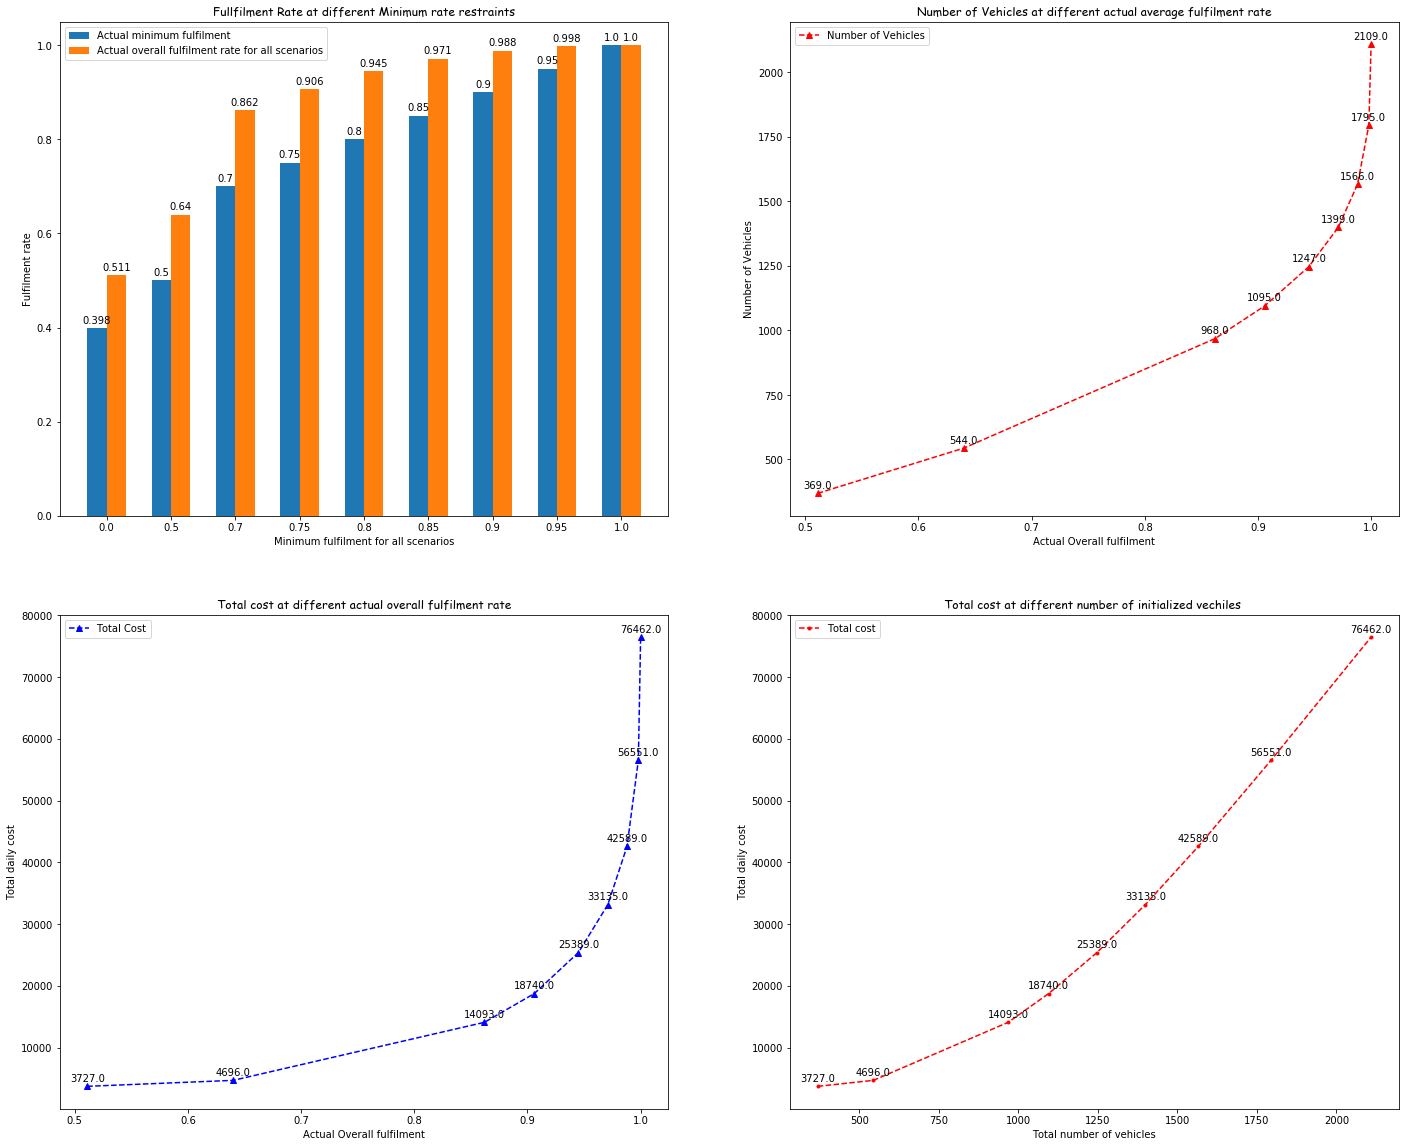

In [ ]:
plot_results(cache_normal_major)

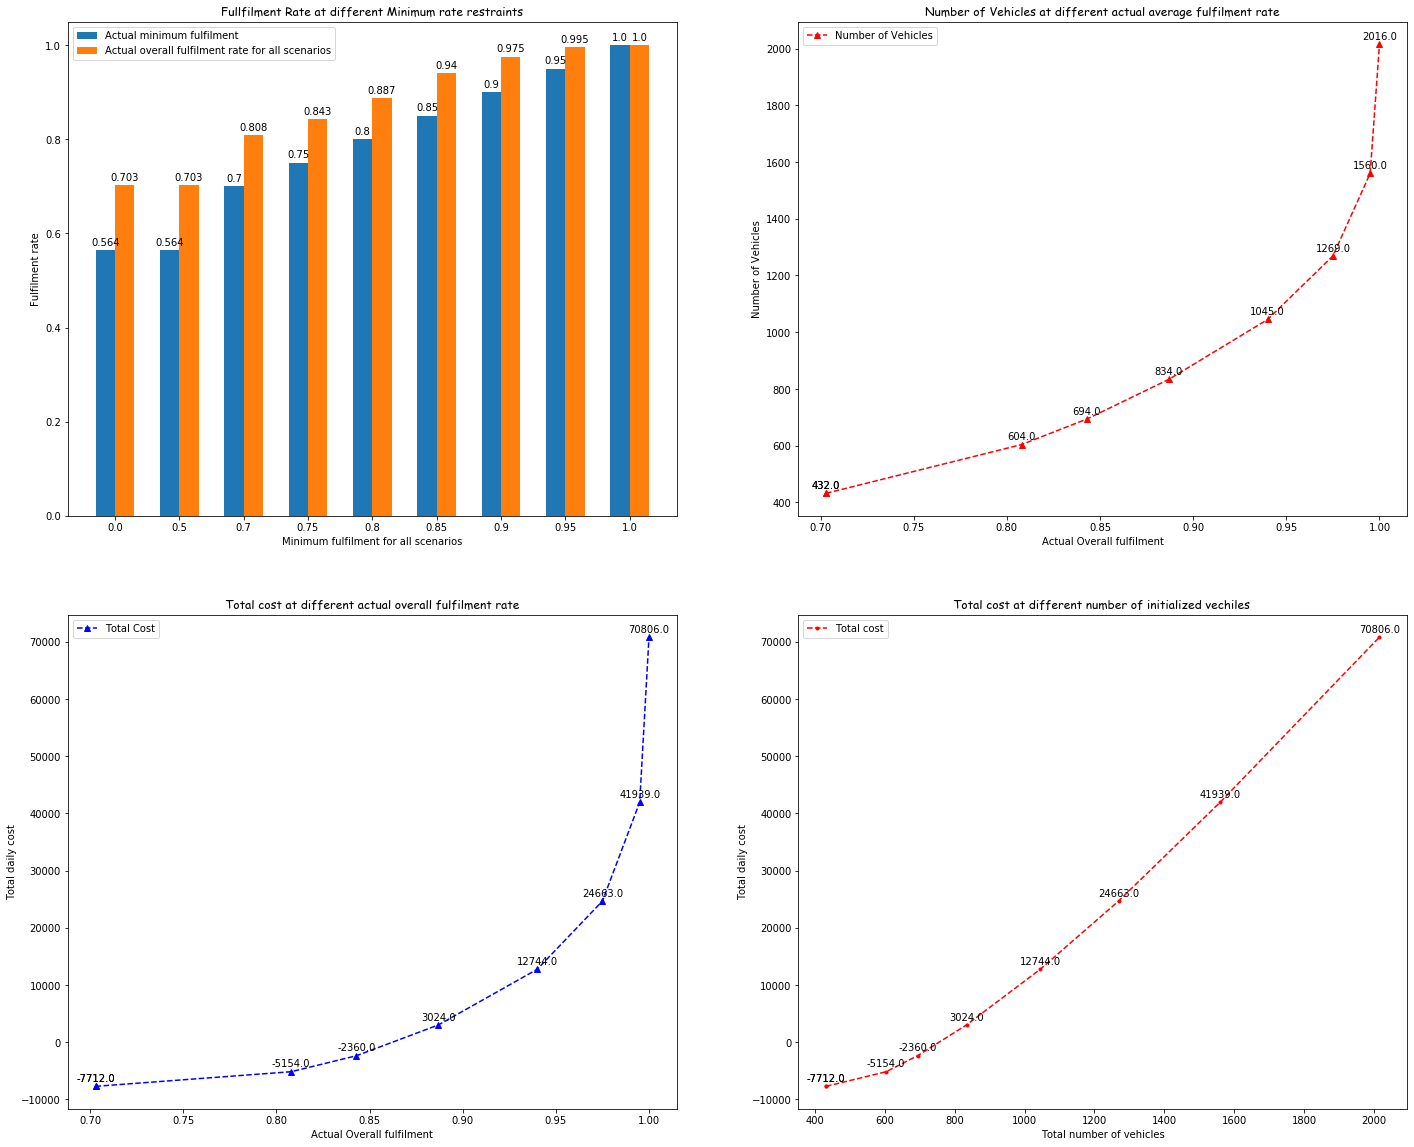

In [ ]:
plot_results(cache_bi_major)

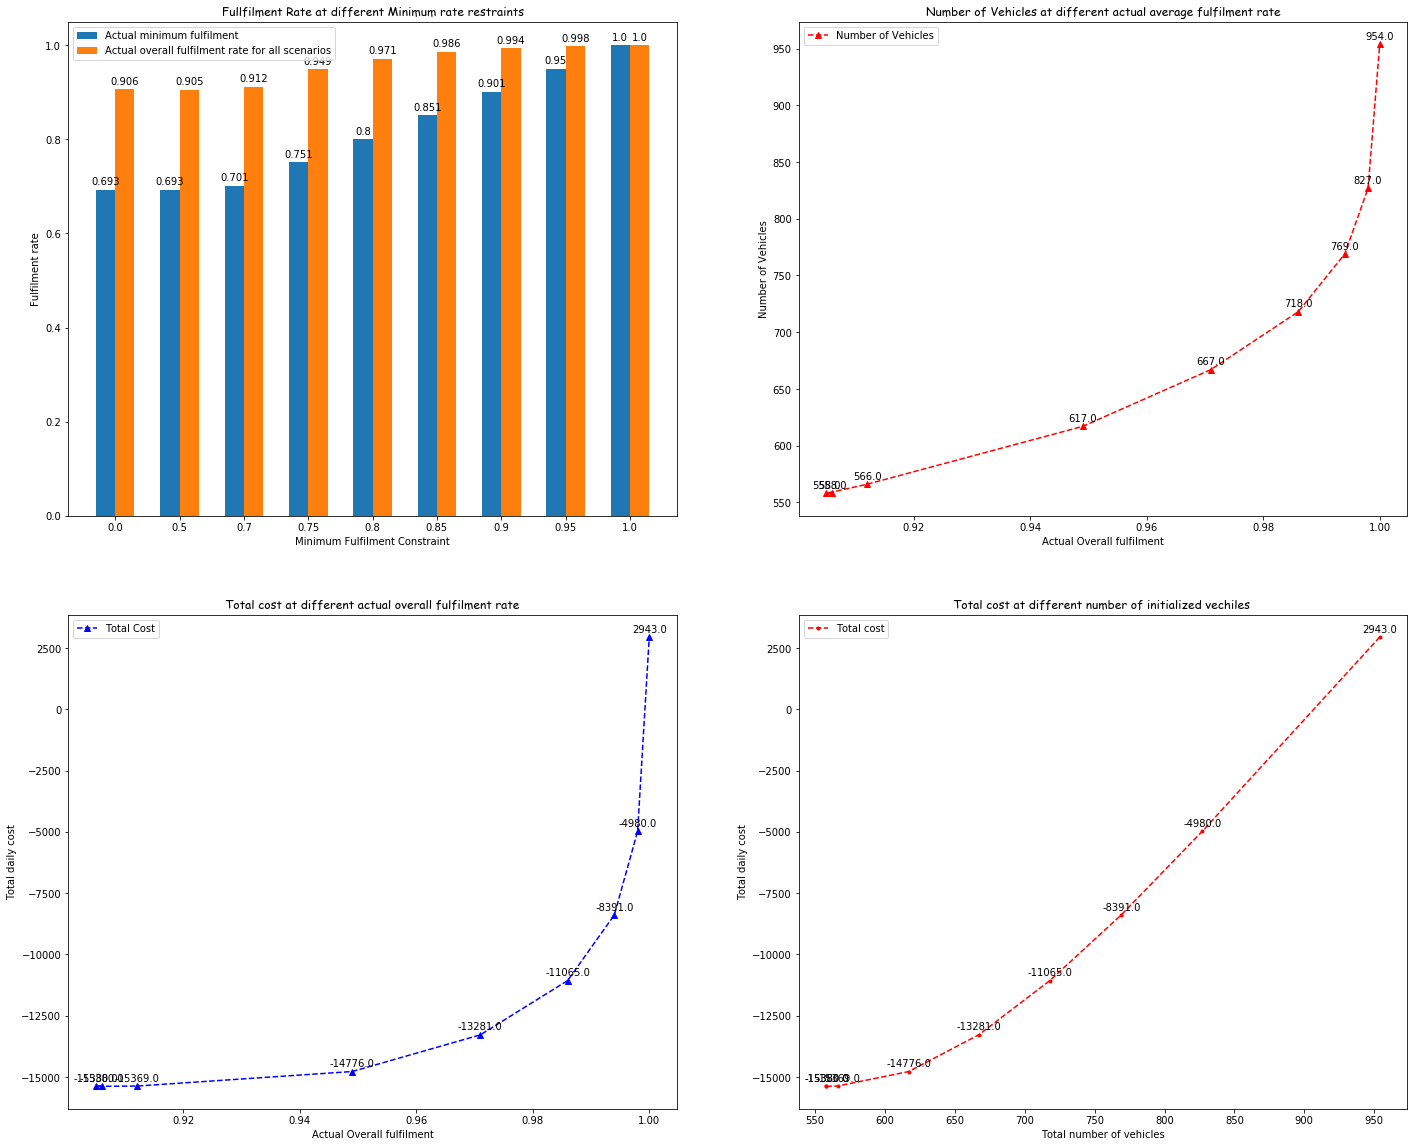

In [ ]:
plot_results(cache_uni_major)

#### Optimal Cost vs Unit deman flow cost 

In [ ]:
cache_price = driver_price()

2
3
4
5
6


In [ ]:
def plot_results_price(cache_lst):

    fig, axs = plt.subplots()
    fig.set_size_inches(10, 8) 
    n = np.array([i for i in range(2,7)])
    x0=n
    y3= np.array([round(cache["total_cost"],0) for cache in cache_lst])
    mark =  np.array([5500 for i in range(2,7)])
    
    def autolabel_plot(plot,x,y,n):
        for i in n:
            plot.annotate("{}".format(y[i]),xy = (x[i],y[i]),xytext=(0,3),textcoords="offset points",
                             ha='center',va='bottom')  


    
    axs.plot(x0,y3,'b^--',label = "Total Cost ($)")
    axs.plot(x0,mark,label = 'Daily budget ($5500)',color='r')

    axs.set_title("Total cost at different unit positive impact r ($)",fontdict = {'fontname':'Comic Sans MS'})
    axs.set(xlabel="Unit positive impact r ($/Time Period)")
    axs.set(ylabel="Total daily cost ($/day)")
    axs.legend()
#     autolabel_plot(axs,x0,y3,n)

    plt.show()

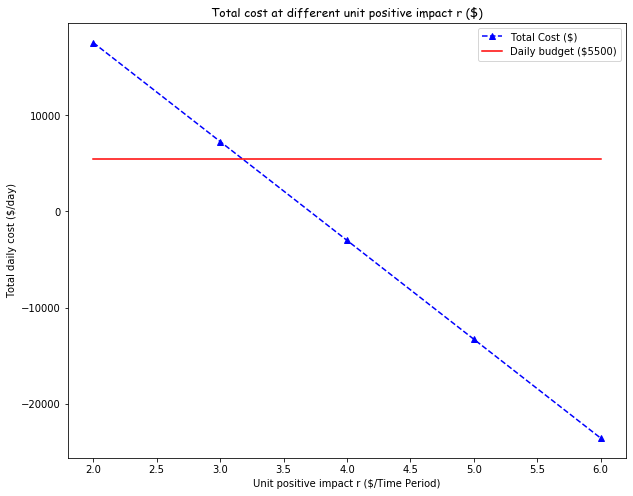

In [ ]:
plot_results_price(cache_price)

In [ ]:
def result_table(cache):

    columns=['Number of Vehicle','Min Fulfill Rate',"Actual Fulfil Rate",'Idle Cost $','Reposition Cost $','Revenue generated $','Penalty $','Total cost $']
    df = pd.DataFrame(columns = columns,index=None)
    
    for i,cache in enumerate(cache):
    #     print(i)
    #     print('avg_cost_idle:', cache['avg_cost_idle'])
    #     print('avg_cost_reposition:', cache['avg_cost_reposition'])
    #     print('avg_cost_revenue:',cache['avg_cost_revenue'])
    #     print('avg_penalty:',cache['avg_penalty'])
    #     print('total_coat:',cache["total_cost"])
#         if i<=2:
#             continue
        df = df.append({
            columns[1]:round(min(cache["actual_rate_list"]),3),
            columns[0]:int(cache['number_of_vehicles']),
            columns[2]:round(cache["actual_fulfilment_rate"],3),
            columns[3]:round(cache['avg_cost_idle'],2),
            columns[4]:round(cache['avg_cost_reposition'],2),
            columns[5]:round(cache['avg_cost_revenue'],2),
            columns[6]:round(cache['avg_penalty'],2),
            columns[7]:round(cache["total_cost"],2)},ignore_index=True)

    return df

In [ ]:
df_bi=result_table(cache_bi_major)
df_bi

,Number of Vehicle,Min Fulfill Rate,Actual Fulfil Rate,Idle Cost $,Reposition Cost $,Revenue generated $,Penalty $,Total cost $
0,432.0,0.564,0.703,730.67,19.24,35540.72,3655.07,-7711.55
1,432.0,0.564,0.703,730.87,19.14,35540.72,3655.47,-7711.55
2,604.0,0.700,0.808,1802.32,17.58,42041.17,2363.64,-5153.71
3,694.0,0.750,0.843,2484.11,12.27,44320.28,1926.67,-2359.90
4,834.0,0.800,0.887,3625.70,5.30,47053.61,1384.24,3024.13
5,1045.0,0.850,0.940,5454.84,3.52,49903.44,741.56,12744.05
6,1269.0,0.900,0.975,7507.63,7.74,51729.67,313.00,24663.39
7,1560.0,0.950,0.995,10322.48,4.76,52717.00,64.82,41938.87
8,2016.0,1.000,1.000,14866.39,0.68,52928.72,0.00,70805.77


In [ ]:
df_uni=result_table(cache_uni_major)
df_uni

,Number of Vehicle,Min Fulfill Rate,Actual Fulfil Rate,Idle Cost $,Reposition Cost $,Revenue generated $,Penalty $,Total cost $
0,558.0,0.693,0.906,764.83,32.87,47634.56,1160.67,-15379.86
1,558.0,0.693,0.905,765.54,32.45,47633.94,1161.84,-15379.86
2,566.0,0.701,0.912,802.84,34.79,48023.06,1078.40,-15369.04
3,617.0,0.751,0.949,1078.34,49.37,50098.61,630.47,-14775.60
4,667.0,0.800,0.971,1446.00,48.71,51391.78,354.11,-13281.40
5,718.0,0.851,0.986,1874.25,49.31,52184.28,176.71,-11065.48
6,769.0,0.901,0.994,2345.32,45.54,52606.06,70.31,-8391.19
7,827.0,0.950,0.998,2929.87,32.14,52787.39,26.58,-4980.11
8,954.0,1.000,1.000,4220.42,15.67,52887.94,0.00,2942.51


In [ ]:
df_normal=result_table(cache_normal_major)
df_normal

,Number of Vehicle,Min Fulfill Rate,Actual Fulfil Rate,Idle Cost $,Reposition Cost $,Revenue generated $,Penalty $,Total cost $
0,369.0,0.398,0.511,1318.64,7.21,23572.39,6011.00,3726.52
1,544.0,0.500,0.640,2279.41,8.57,31438.33,4427.98,4696.46
2,968.0,0.700,0.862,5142.48,14.09,45104.50,1698.29,14092.83
3,1095.0,0.750,0.906,6137.19,18.18,47787.33,1151.51,18740.43
4,1247.0,0.800,0.945,7417.39,19.40,50157.39,674.18,25388.58
5,1399.0,0.850,0.971,8782.16,21.22,51674.94,354.51,33135.03
6,1566.0,0.900,0.988,10366.59,17.39,52596.94,150.84,42588.83
7,1795.0,0.950,0.998,12620.19,10.44,53090.67,29.18,56551.37
8,2109.0,1.000,1.000,15764.65,2.55,53204.11,0.00,76461.84


In [ ]:
def comparison(cache_list):

    fig, axs = plt.subplots()
    fig.set_size_inches(10, 8) 
    

    labels = ['Uniform','Normal','Bimodal']
    colors = ['b','orange','green']
    
    for i,cache_lst in enumerate(cache_list):
        y_overall_rate=np.array([round(cache['total_cost'],3) for cache in cache_lst])
        y_num_vehicle=np.array([cache["number_of_vehicles"] for cache in cache_lst])
#         y_total_coast=np.array([round(cache["total_cost"],0) for cache in cache_lst])
        
        axs.plot(y_num_vehicle,y_overall_rate,'^--',label = labels[i],color = colors[i])
#         axs.plot(y_overall_rate,y_total_coast,label = labels[i])



#     axs.set_title("Total cost at different unit positive impact r ($)",fontdict = {'fontname':'Comic Sans MS'})
    axs.set(xlabel="Fleet size")
    axs.set(ylabel="Total daily cost ($/day)")
    axs.legend()
#     autolabel_plot(axs,x0,y3,n)

    plt.show()

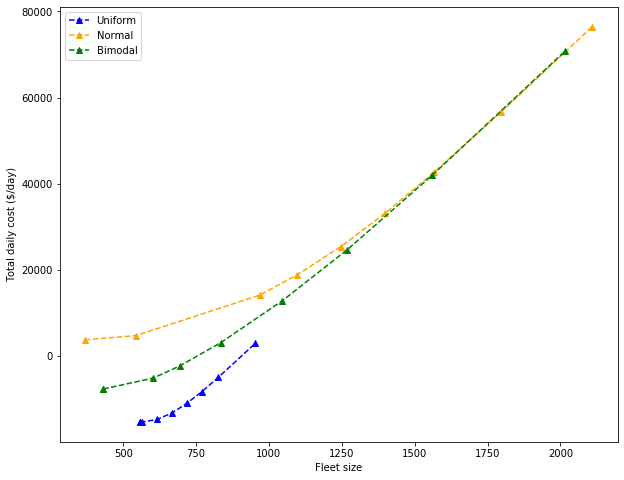

In [ ]:
comparison([cache_uni_major,cache_normal_major,cache_bi_major])